# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
import pandas as pd
#plt.style.use('dark_background')  
from mpl_toolkits.mplot3d import Axes3D

lib = ctypes.CDLL("../target/release/mymodel.dll")

lib.create_mlp_model.argtypes = [ctypes.c_size_t, ctypes.c_size_t, ctypes.c_double, ctypes.c_size_t,ctypes.c_bool,ctypes.c_bool]
lib.create_mlp_model.restype = ctypes.c_void_p

lib.train_mlp_model.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t, ctypes.c_size_t
]
lib.train_mlp_model.restype = None

lib.predict_mlp_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double), ctypes.c_size_t]
lib.predict_mlp_model.restype = ctypes.c_double

lib.create_mlp_classifier.argtypes = [
    ctypes.c_size_t,  # n_inputs
    ctypes.c_size_t,  # n_hidden
    ctypes.c_size_t,  # n_classes
    ctypes.c_double,  # learning_rate
    ctypes.c_size_t   # epochs
]
lib.create_mlp_classifier.restype = ctypes.c_void_p
lib.train_mlp_classifier.argtypes = [
    ctypes.c_void_p,                   # model_ptr
    ctypes.POINTER(ctypes.c_double),  # x_ptr
    ctypes.POINTER(ctypes.c_uint32),  # y_ptr
    ctypes.c_size_t,                  # n_samples
    ctypes.c_size_t                   # n_features
]
lib.train_mlp_classifier.restype = None

lib.predict_mlp_classifier.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t
]
lib.predict_mlp_classifier.restype = ctypes.c_uint32

In [2]:
def train_predict_model(lib, X, Y,
                        task: str = "classification",  # "classification", "regression", "multiclass"
                        n_hidden: int = 6,
                        learning_rate: float = 0.1,
                        epochs: int = 1000,
                        verbose: bool = True,
                        n_classes: int = None,
                        use_activation: bool = True):  

    X = np.array(X, dtype=np.float64)
    n_samples, n_features = X.shape

    if task in {"regression", "classification"}:
        Y = np.array(Y, dtype=np.float64)
        is_regression = (task == "regression")

        model = lib.create_mlp_model(n_features, n_hidden, learning_rate, epochs, is_regression, use_activation)

        lib.train_mlp_model(
            model,
            X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            n_samples,
            n_features
        )

        Y_pred = np.array([
            lib.predict_mlp_model(
                model,
                np.array(x, dtype=np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                n_features
            )
            for x in X
        ])

        if task == "classification":
            Y_pred = (Y_pred >= 0).astype(np.uint32)  # tanh → seuil 0

    elif task == "multiclass":
        if n_classes is None:
            raise ValueError("n_classes doit être fourni pour task='multiclass'")
        Y = np.array(Y, dtype=np.uint32)
        model = lib.create_mlp_classifier(n_features, n_hidden, n_classes, learning_rate, epochs)

        lib.train_mlp_classifier(
            model,
            X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            Y.ctypes.data_as(ctypes.POINTER(ctypes.c_uint32)),
            n_samples,
            n_features
        )

        Y_pred = np.array([
            lib.predict_mlp_classifier(
                model,
                np.array(x, dtype=np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                n_features
            )
            for x in X
        ], dtype=np.uint32)

    else:
        raise ValueError("task doit être 'regression', 'classification' ou 'multiclass'.")

    return model, Y_pred


# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

Prédictions MLP :
[1.0, 1.0] → attendu : 1, sortie : 0.979 → classe prédite : 1
[2.0, 3.0] → attendu : -1, sortie : -0.987 → classe prédite : 0
[3.0, 3.0] → attendu : -1, sortie : -0.987 → classe prédite : 0

Prédiction : 33.33% 


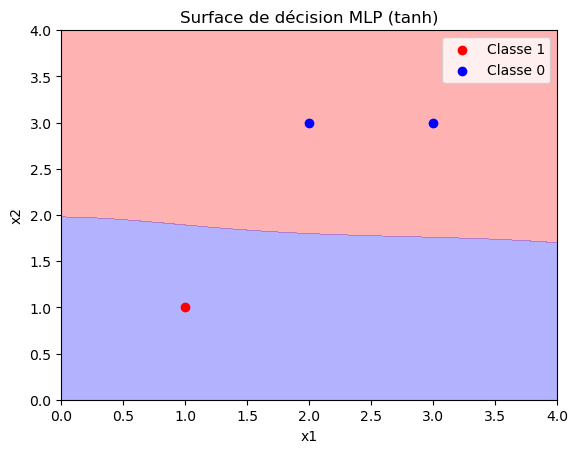

<Figure size 640x480 with 0 Axes>

In [3]:
X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
], dtype=np.float64)
Y = np.array([1, -1, -1], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(lib, X, Y, task="classification")

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_mlp_model(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

print("Prédictions MLP :")
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe = 1 if out >= 0 else 0
    print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {out:.3f} → classe prédite : {classe}")

Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (Y_pred >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"\nPrédiction : {accuracy * 100:.2f}% ")

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(point) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[0, 0], X[0, 1], color="red", label="Classe 1")   # Y[0] = 1
plt.scatter(X[1:, 0], X[1:, 1], color="blue", label="Classe 0")  # Y[1:] = -1
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Surface de décision MLP (tanh)")
plt.legend()
plt.show()
plt.clf()

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

Prédictions multiclasses :
[1.18912149 1.09378553] → classe prédite : 0, vraie : 0
[1.13931477 1.05225537] → classe prédite : 0, vraie : 0
[1.31101583 1.53960516] → classe prédite : 0, vraie : 0
[1.52419181 1.4124711 ] → classe prédite : 0, vraie : 0
[1.57802963 1.13546477] → classe prédite : 0, vraie : 0
[1.6039317 1.0489185] → classe prédite : 0, vraie : 0
[1.58733298 1.57122839] → classe prédite : 0, vraie : 0
[1.24515839 1.0835212 ] → classe prédite : 0, vraie : 0
[1.77747216 1.3730109 ] → classe prédite : 0, vraie : 0
[1.50285054 1.27931155] → classe prédite : 0, vraie : 0
[1.20036699 1.24658438] → classe prédite : 0, vraie : 0
[1.30410098 1.26607484] → classe prédite : 0, vraie : 0
[1.47404388 1.31083307] → classe prédite : 0, vraie : 0
[1.38743171 1.69798065] → classe prédite : 0, vraie : 0
[1.55261302 1.20208756] → classe prédite : 0, vraie : 0
[1.34734562 1.64574363] → classe prédite : 0, vraie : 0
[1.83115771 1.11708167] → classe prédite : 0, vraie : 0
[1.74595977 1.47585911]

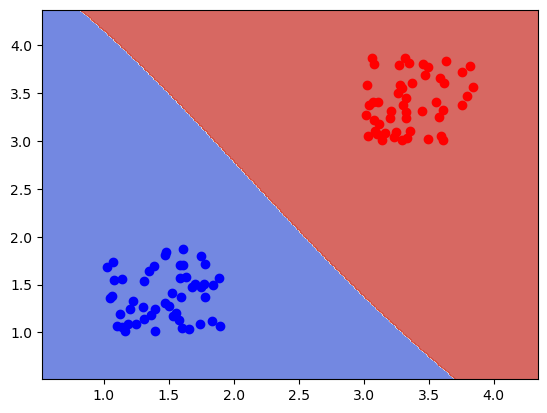

<Figure size 640x480 with 0 Axes>

In [5]:
X = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([3, 3])
]).astype(np.float64)

Y = np.concatenate([
    np.zeros((50,), dtype=np.uint32),
    np.ones((50,), dtype=np.uint32)
])

model_ptr, Y_pred = train_predict_model(lib, X, Y, task="multiclass", n_classes=2)

accuracy = (Y_pred == Y).sum() / len(Y) * 100

print("Prédictions multiclasses :")
for i in range(len(X)):
    print(f"{X[i]} → classe prédite : {Y_pred[i]}, vraie : {Y[i]}")
print(f"\nPrécision : {accuracy:.2f}% ")

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([
    lib.predict_mlp_classifier(
        model_ptr,
        np.array(point, dtype=np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    ) for point in grid
])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[0:50, 0], X[0:50, 1], color="blue")
plt.scatter(X[50:100, 0], X[50:100, 1], color="red")
plt.show()
plt.clf()

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK

[1, 0] => attendu: 1, prédit: 0.979 → classe 1
[0, 1] => attendu: 1, prédit: 0.977 → classe 1
[0, 0] => attendu: -1, prédit: -0.985 → classe -1
[1, 1] => attendu: -1, prédit: -0.977 → classe -1

Précision : 100.00% (4/4)


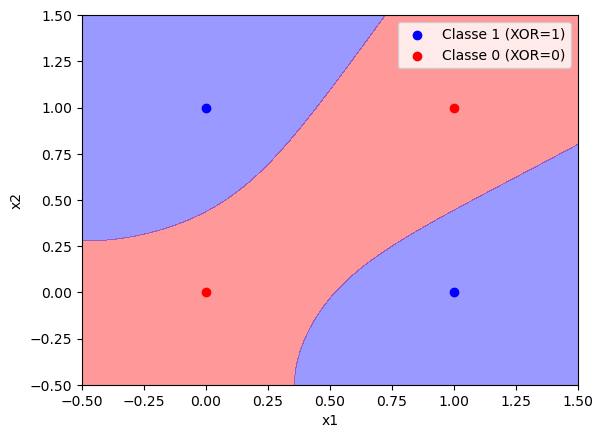

In [6]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="classification",
    n_hidden=4,
    learning_rate=0.1,
    epochs=2000
)

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_mlp_model(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

correct = 0
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe_pred = 1 if out >= 0 else -1
    print(f"{xi.tolist()} => attendu: {int(yi)}, prédit: {out:.3f} → classe {classe_pred}")
    if classe_pred == yi:
        correct += 1

accuracy = correct / len(Y) * 100
print(f"\nPrécision : {accuracy:.2f}% ({correct}/{len(Y)})")

x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(point) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.4, colors=["red", "blue"])
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color="blue", label="Classe 1 (XOR=1)")
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color="red", label="Classe 0 (XOR=0)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


x = [0.80151404 0.05367996] → vrai = 1.0, prédit = 1.000
x = [0.26209269 0.21682618] → vrai = 1.0, prédit = 1.000
x = [-0.30111181 -0.32485611] → vrai = -1.0, prédit = 1.000
x = [ 0.103076  -0.5323401] → vrai = 1.0, prédit = 1.000
x = [-0.29657549  0.00100333] → vrai = 1.0, prédit = 1.000
x = [-0.69174055 -0.3891896 ] → vrai = -1.0, prédit = 0.000
x = [-0.18762193 -0.39673181] → vrai = 1.0, prédit = 1.000
x = [ 0.8125458  -0.28062738] → vrai = 1.0, prédit = 1.000
x = [ 0.14517497 -0.75147921] → vrai = 1.0, prédit = 1.000
x = [0.73920622 0.06818803] → vrai = 1.0, prédit = 1.000

Précision  : 53.80% 


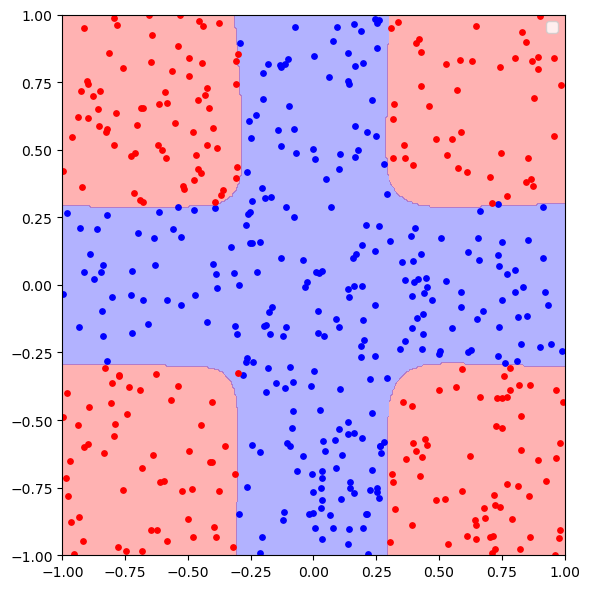

In [10]:
X = np.random.random((500, 2)) * 2.0 - 1.0  
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(lib, X, Y, n_hidden=10, learning_rate=0.01, epochs=3000)

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_mlp_model(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

xx, yy = np.meshgrid(np.linspace(-1.0, 1.0, 300), np.linspace(-1.0, 1.0, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(p) for p in grid])
Z_classe = (Z >= 0).astype(np.int32).reshape(xx.shape)

pred_classes = (Y_pred >= 0).astype(np.int32)
true_classes = (Y >= 0).astype(np.int32)
accuracy = (pred_classes == true_classes).sum() / len(Y) * 100

for i in range(10):
    print(f"x = {X[i]} → vrai = {Y[i]}, prédit = {Y_pred[i]:.3f}")

print(f"\nPrécision  : {accuracy:.2f}% ")

plt.figure(figsize=(6, 6))

plt.contourf(xx, yy, Z_classe, levels=[-0.5, 0.5, 1.5], colors=["red", "blue"], alpha=0.3)

plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color="blue", s=15)
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color="red", s=15)

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

x = [ 0.95603595 -0.28595001] → vrai = 2, prédit = 2
x = [ 0.22116872 -0.71503271] → vrai = 2, prédit = 2
x = [0.5740659  0.16121379] → vrai = 1, prédit = 1
x = [-0.47545705  0.02419671] → vrai = 1, prédit = 1
x = [0.39913511 0.75123769] → vrai = 1, prédit = 1
x = [-0.27606231 -0.31727946] → vrai = 0, prédit = 0
x = [0.5074391  0.01574251] → vrai = 1, prédit = 1
x = [-0.49455732  0.21825525] → vrai = 1, prédit = 1
x = [-0.85240815 -0.65141254] → vrai = 0, prédit = 0
x = [-0.22289601  0.08104976] → vrai = 1, prédit = 1

Précision  : 100.00% 


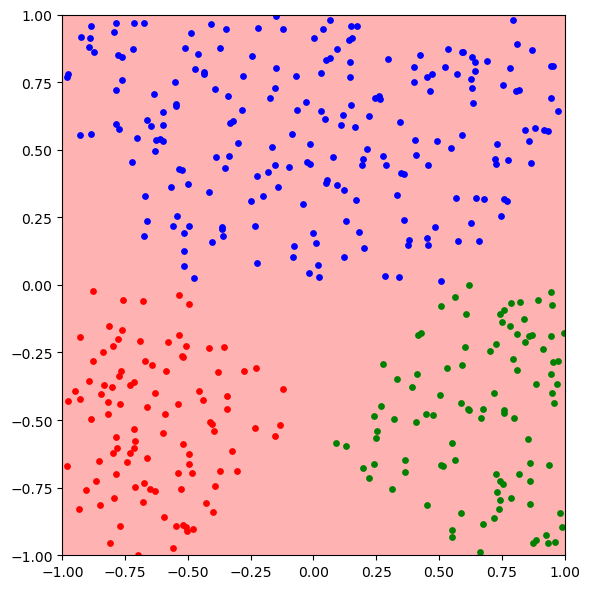

In [12]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array(
    [
        (
            [1, 0, 0]
            if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0
            else (
                [0, 1, 0]
                if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0
                else (
                    [0, 0, 1]
                    if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0
                    else [0, 0, 0]
                )
            )
        )
        for p in X
    ]
)
valid = Y.sum(axis=1) > 0
X = X[valid]
Y = Y[valid]
labels = np.argmax(Y, axis=1).astype(np.uint32)
model_ptr = lib.create_mlp_classifier(X.shape[1], 10, 3, 0.1, 3000)

lib.train_mlp_classifier(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    labels.ctypes.data_as(ctypes.POINTER(ctypes.c_uint32)),
    X.shape[0],
    X.shape[1]
)

predicted = np.array([
    lib.predict_mlp_classifier(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    ) for x in X
])
accuracy = (predicted == labels).sum() / len(labels) * 100
for i in range(10):
    print(f"x = {X[i]} → vrai = {labels[i]}, prédit = {predicted[i]}")
print(f"\nPrécision  : {accuracy:.2f}% ")

def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_mlp_model(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np)
    )

xx, yy = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(p) for p in grid])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5, 2.5], colors=["red", "blue", "green"], alpha=0.3)

colors = ["red", "blue", "green"]
for i in range(3):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], color=colors[i], s=15, label=f"Classe {i}")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

### Multi Cross :


x = [-0.32593526 -0.86352332], vrai = 2, prédit = 2
x = [ 0.06792967 -0.52468561], vrai = 0, prédit = 0
x = [-0.90000274  0.53558889], vrai = 2, prédit = 2
x = [-0.12536253 -0.22881849], vrai = 2, prédit = 2
x = [ 0.28870314 -0.73309066], vrai = 2, prédit = 2
x = [-0.48031273 -0.64708226], vrai = 0, prédit = 0
x = [-0.8460517   0.15885287], vrai = 2, prédit = 0
x = [-0.06995299 -0.78341832], vrai = 1, prédit = 2
x = [-0.78213558 -0.58352966], vrai = 0, prédit = 0
x = [-0.87964765 -0.19453301], vrai = 0, prédit = 0

Précision : 69.90% 


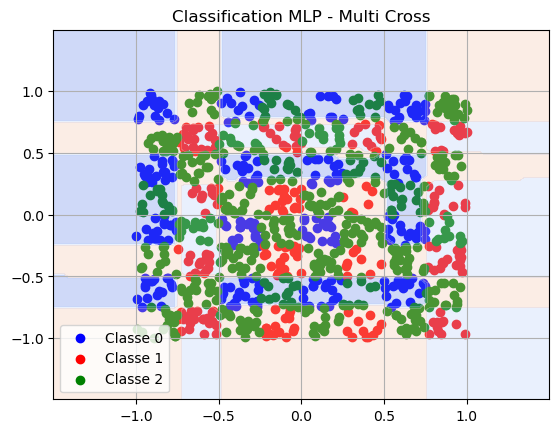

<Figure size 640x480 with 0 Axes>

In [13]:
X = np.random.random((1000, 2)) * 2.0 - 1.0

def cross_label(p):
    cond0 = abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25
    cond1 = abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25
    if cond0:
        return [1, 0, 0]
    elif cond1:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

Y = np.array([cross_label(p) for p in X])
Y_labels = np.argmax(Y, axis=1)  # labels 0, 1, 2

model_ptr, Y_pred = train_predict_model(
    lib, X, Y_labels,
    task="multiclass",
    n_hidden=10,
    learning_rate=0.05,
    epochs=4000,
    n_classes=3
)

plt.scatter(X[Y[:, 0] == 1][:, 0], X[Y[:, 0] == 1][:, 1], color="blue", label="Classe 0")
plt.scatter(X[Y[:, 1] == 1][:, 0], X[Y[:, 1] == 1][:, 1], color="red", label="Classe 1")
plt.scatter(X[Y[:, 2] == 1][:, 0], X[Y[:, 2] == 1][:, 1], color="green", label="Classe 2")

xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([
    lib.predict_mlp_classifier(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    )
    for point in grid_points
])
Z = Z.reshape(xx.shape)


correct = sum(y_true == y_pred for y_true, y_pred in zip(Y_labels, Y_pred))
total = len(Y_labels)
accuracy = correct * 100 / total

for i in range(10):  #
    print(f"x = {X[i]}, vrai = {Y_labels[i]}, prédit = {Y_pred[i]}")

print(f"\nPrécision : {accuracy:.2f}% ")

plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, 4, 1), cmap="coolwarm")
plt.legend()
plt.title("Classification MLP - Multi Cross")
plt.grid(True)
plt.show()
plt.clf()




## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

x = 1.0 → y attendu = 2.0, y prédit = 2.000
x = 2.0 → y attendu = 3.0, y prédit = 3.000

MAE (erreur absolue moyenne) : 0.0000
RMSE (erreur quadratique moyenne) : 0.0000
Précisio : 100.00%


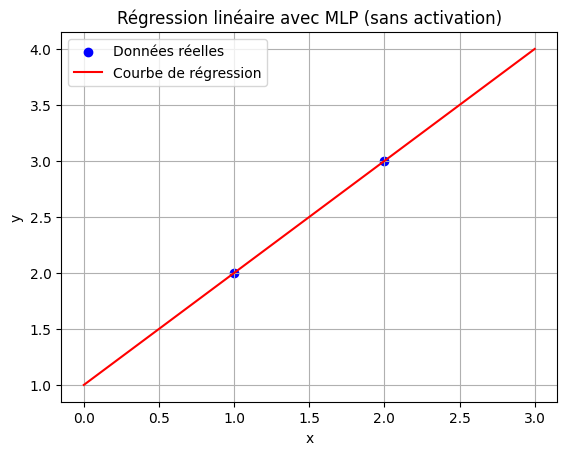

<Figure size 640x480 with 0 Axes>

In [97]:
X = np.array([[1], [2]], dtype=np.float64)
Y = np.array([2, 3], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="regression",
    n_hidden=1,        
    learning_rate=0.1,
    epochs=5000,
    use_activation=False
)

for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x[0]:.1f} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")
mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
value_range = Y.max() - Y.min()
accuracy_pct = 100 * (1 - rmse / value_range) if value_range > 0 else 100.0
print(f"\nMAE (erreur absolue moyenne) : {mae:.4f}")
print(f"RMSE (erreur quadratique moyenne) : {rmse:.4f}")
print(f"Précisio : {accuracy_pct:.2f}%")

x_test = np.linspace(0, 3, 100).reshape(-1, 1)
y_test_pred = np.array([
    lib.predict_mlp_model(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        x.shape[0]
    )
    for x in x_test
])

plt.scatter(X, Y, label="Données réelles", color="blue")
plt.plot(x_test, y_test_pred, color="red", label="Courbe de régression")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Régression linéaire avec MLP (sans activation)")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

x = 1.0 → y attendu = 2.0, y prédit = 2.000
x = 2.0 → y attendu = 3.0, y prédit = 3.000
x = 3.0 → y attendu = 2.5, y prédit = 2.500

MAE : 0.0000
RMSE : 0.0000
Précision ±0.1 : 100.00%


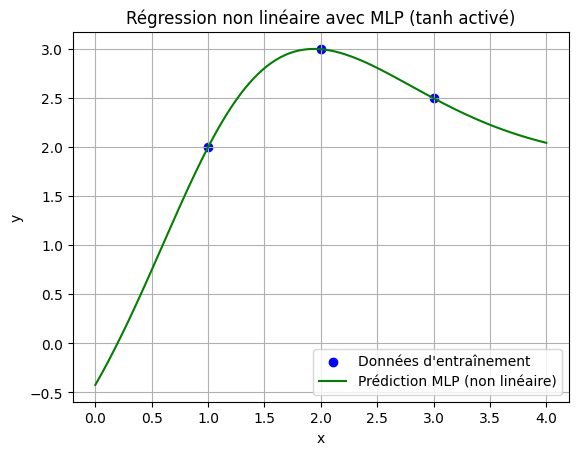

<Figure size 640x480 with 0 Axes>

In [99]:
X = np.array([[1], [2], [3]], dtype=np.float64)
Y = np.array([2, 3, 2.5], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="regression",
    n_hidden=5,
    learning_rate=0.03,
    epochs=3000,
    use_activation=True  
)

for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x[0]:.1f} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")

mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
threshold = 0.1
accuracy = np.sum(np.abs(Y - Y_pred) <= threshold) / len(Y) * 100

print(f"\nMAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Précision ±{threshold} : {accuracy:.2f}%")

x_test = np.linspace(0, 4, 200).reshape(-1, 1)
y_test_pred = np.array([
    lib.predict_mlp_model(
        model_ptr,
        x.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        x.shape[0]
    )
    for x in x_test
])

plt.title("Régression non linéaire avec MLP (tanh activé)")
plt.scatter(X, Y, label="Données d'entraînement", color="blue")
plt.plot(x_test, y_test_pred, label="Prédiction MLP (non linéaire)", color="green")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()


### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

x = [1. 1.] → y attendu = 2.0, y prédit = 2.000
x = [2. 2.] → y attendu = 3.0, y prédit = 3.000
x = [3. 1.] → y attendu = 2.5, y prédit = 2.500

MAE : 0.0000
RMSE : 0.0000
Précision ±0.1 : 100.00%


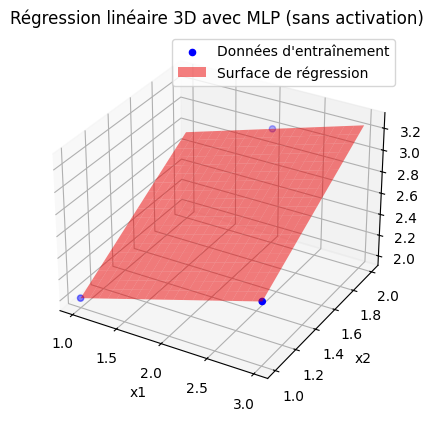

In [100]:

X = np.array([
    [1, 1],
    [2, 2],
    [3, 1]
], dtype=np.float64)

Y = np.array([2, 3, 2.5], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="regression",
    n_hidden=3,
    learning_rate=0.05,
    epochs=3000,
    use_activation=False  # LINEAIRE
)

for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")

mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
threshold = 0.1
accuracy = np.sum(np.abs(Y - Y_pred) <= threshold) / len(Y) * 100

print(f"\nMAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Précision ±{threshold} : {accuracy:.2f}%")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Données d'entraînement")

x_grid, y_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 20),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
)
xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

z_pred = np.array([
    lib.predict_mlp_model(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    ) for point in xy_grid
])
z_grid = z_pred.reshape(x_grid.shape)

ax.plot_surface(x_grid, y_grid, z_grid, color='red', alpha=0.5, label="Surface de régression")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire 3D avec MLP (sans activation)")
plt.legend()
plt.show()


### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

x = [1. 1.] → y attendu = 1.0, y prédit = 1.000
x = [2. 2.] → y attendu = 2.0, y prédit = 2.000
x = [3. 3.] → y attendu = 3.0, y prédit = 3.000

MAE : 0.0000
RMSE : 0.0000
Précision ±0.1 : 100.00%


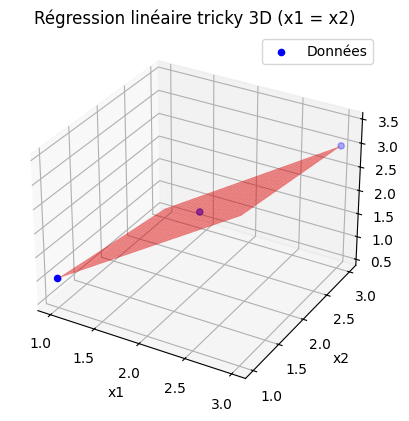

In [101]:
X = np.array([
    [1, 1],
    [2, 2],
    [3, 3]
], dtype=np.float64)

Y = np.array([1, 2, 3], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="regression",
    n_hidden=2,
    learning_rate=0.01,
    epochs=3000,
    use_activation= False
)

for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")
mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
threshold = 0.1
accuracy = np.sum(np.abs(Y - Y_pred) <= threshold) / len(Y) * 100

print(f"\nMAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Précision ±{threshold} : {accuracy:.2f}%")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Données")

x_grid, y_grid = np.meshgrid(
    np.linspace(1, 3, 20),
    np.linspace(1, 3, 20)
)
xy_flat = np.c_[x_grid.ravel(), y_grid.ravel()]
z_pred = np.array([
    lib.predict_mlp_model(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    ) for point in xy_flat
])
z_grid = z_pred.reshape(x_grid.shape)

ax.plot_surface(x_grid, y_grid, z_grid, color='red', alpha=0.5)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression linéaire tricky 3D (x1 = x2)")
plt.legend()
plt.show()


### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

x = [1. 0.] → y attendu = 2.0, y prédit = 2.000
x = [0. 1.] → y attendu = 1.0, y prédit = 1.000
x = [1. 1.] → y attendu = -2.0, y prédit = -2.000
x = [0. 0.] → y attendu = -1.0, y prédit = -1.000

MAE : 0.0000
RMSE : 0.0000
Précision ±0.1 : 100.00%


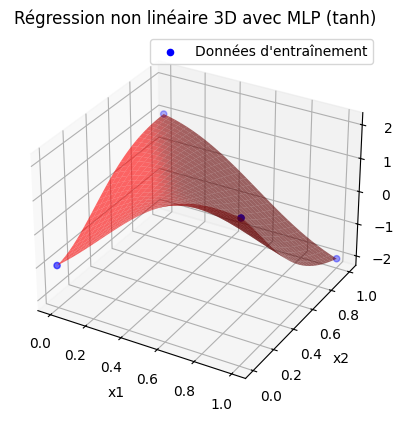

In [102]:
X = np.array([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0]
], dtype=np.float64)

Y = np.array([2, 1, -2, -1], dtype=np.float64)

model_ptr, Y_pred = train_predict_model(
    lib, X, Y,
    task="regression",
    n_hidden=6,
    learning_rate=0.05,
    epochs=5000,
    use_activation=True  # tanh activé
)

for x, y_true, y_hat in zip(X, Y, Y_pred):
    print(f"x = {x} → y attendu = {y_true:.1f}, y prédit = {y_hat:.3f}")
mae = np.mean(np.abs(Y - Y_pred))
rmse = np.sqrt(np.mean((Y - Y_pred)**2))
threshold = 0.1
accuracy = np.sum(np.abs(Y - Y_pred) <= threshold) / len(Y) * 100

print(f"\nMAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"Précision ±{threshold} : {accuracy:.2f}%")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, c='blue', label="Données d'entraînement")

x_grid, y_grid = np.meshgrid(
    np.linspace(0, 1, 30),
    np.linspace(0, 1, 30)
)
xy_points = np.c_[x_grid.ravel(), y_grid.ravel()]
z_pred = np.array([
    lib.predict_mlp_model(
        model_ptr,
        point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    )
    for point in xy_points
])
z_grid = z_pred.reshape(x_grid.shape)

ax.plot_surface(x_grid, y_grid, z_grid, color='red', alpha=0.6)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression non linéaire 3D avec MLP (tanh)")
plt.legend()
plt.show()
